<a href="https://colab.research.google.com/github/sach-krishna/Sentiment-analysis-of-all-TS-lyrics-ever-written/blob/main/tslyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import zipfile
import os
# Extract the uploaded zip file
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Check if extraction worked
os.listdir('data')

['Albums.csv', 'Albums', 'Tabular', 'Cover_Art']

In [9]:
# Install required packages
!pip install textblob vaderSentiment

# Import everything we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import nltk
import os
import glob
from pathlib import Path
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading complete dataset...
Loading album metadata...
Loaded 63 albums from metadata file
Album metadata loaded successfully.
Loading lyrics from files...
Found 64 album folders in /content/data/Albums

Successfully loaded 879 songs with lyrics
Average words per song: 446.1
Lyrics loaded successfully.
Merging with track listings...
Loading track listings for merging...
Found 63 album track listing files in /content/data/Tabular
Attempting to merge lyrics data with track listings...
Merge attempt complete. Successfully matched track IDs for 173 songs.
Complete dataset loaded with 879 songs across 64 albums
DATASET OVERVIEW
Total songs: 879
Total albums: 64
Average songs per album: 13.7
Total words across all songs: 392,135
Average words per song: 446.1
Longest song: 27486 words
Shortest song: 6 words

Albums in dataset:
  1989: 14 songs
  1989_TaylorsVersion_: 22 songs
  1989_TaylorsVersion__Deluxe_: 23 songs
  1989_TaylorsVersion__TangerineEdition_: 23 songs
  1989_TaylorsVersion__Webs

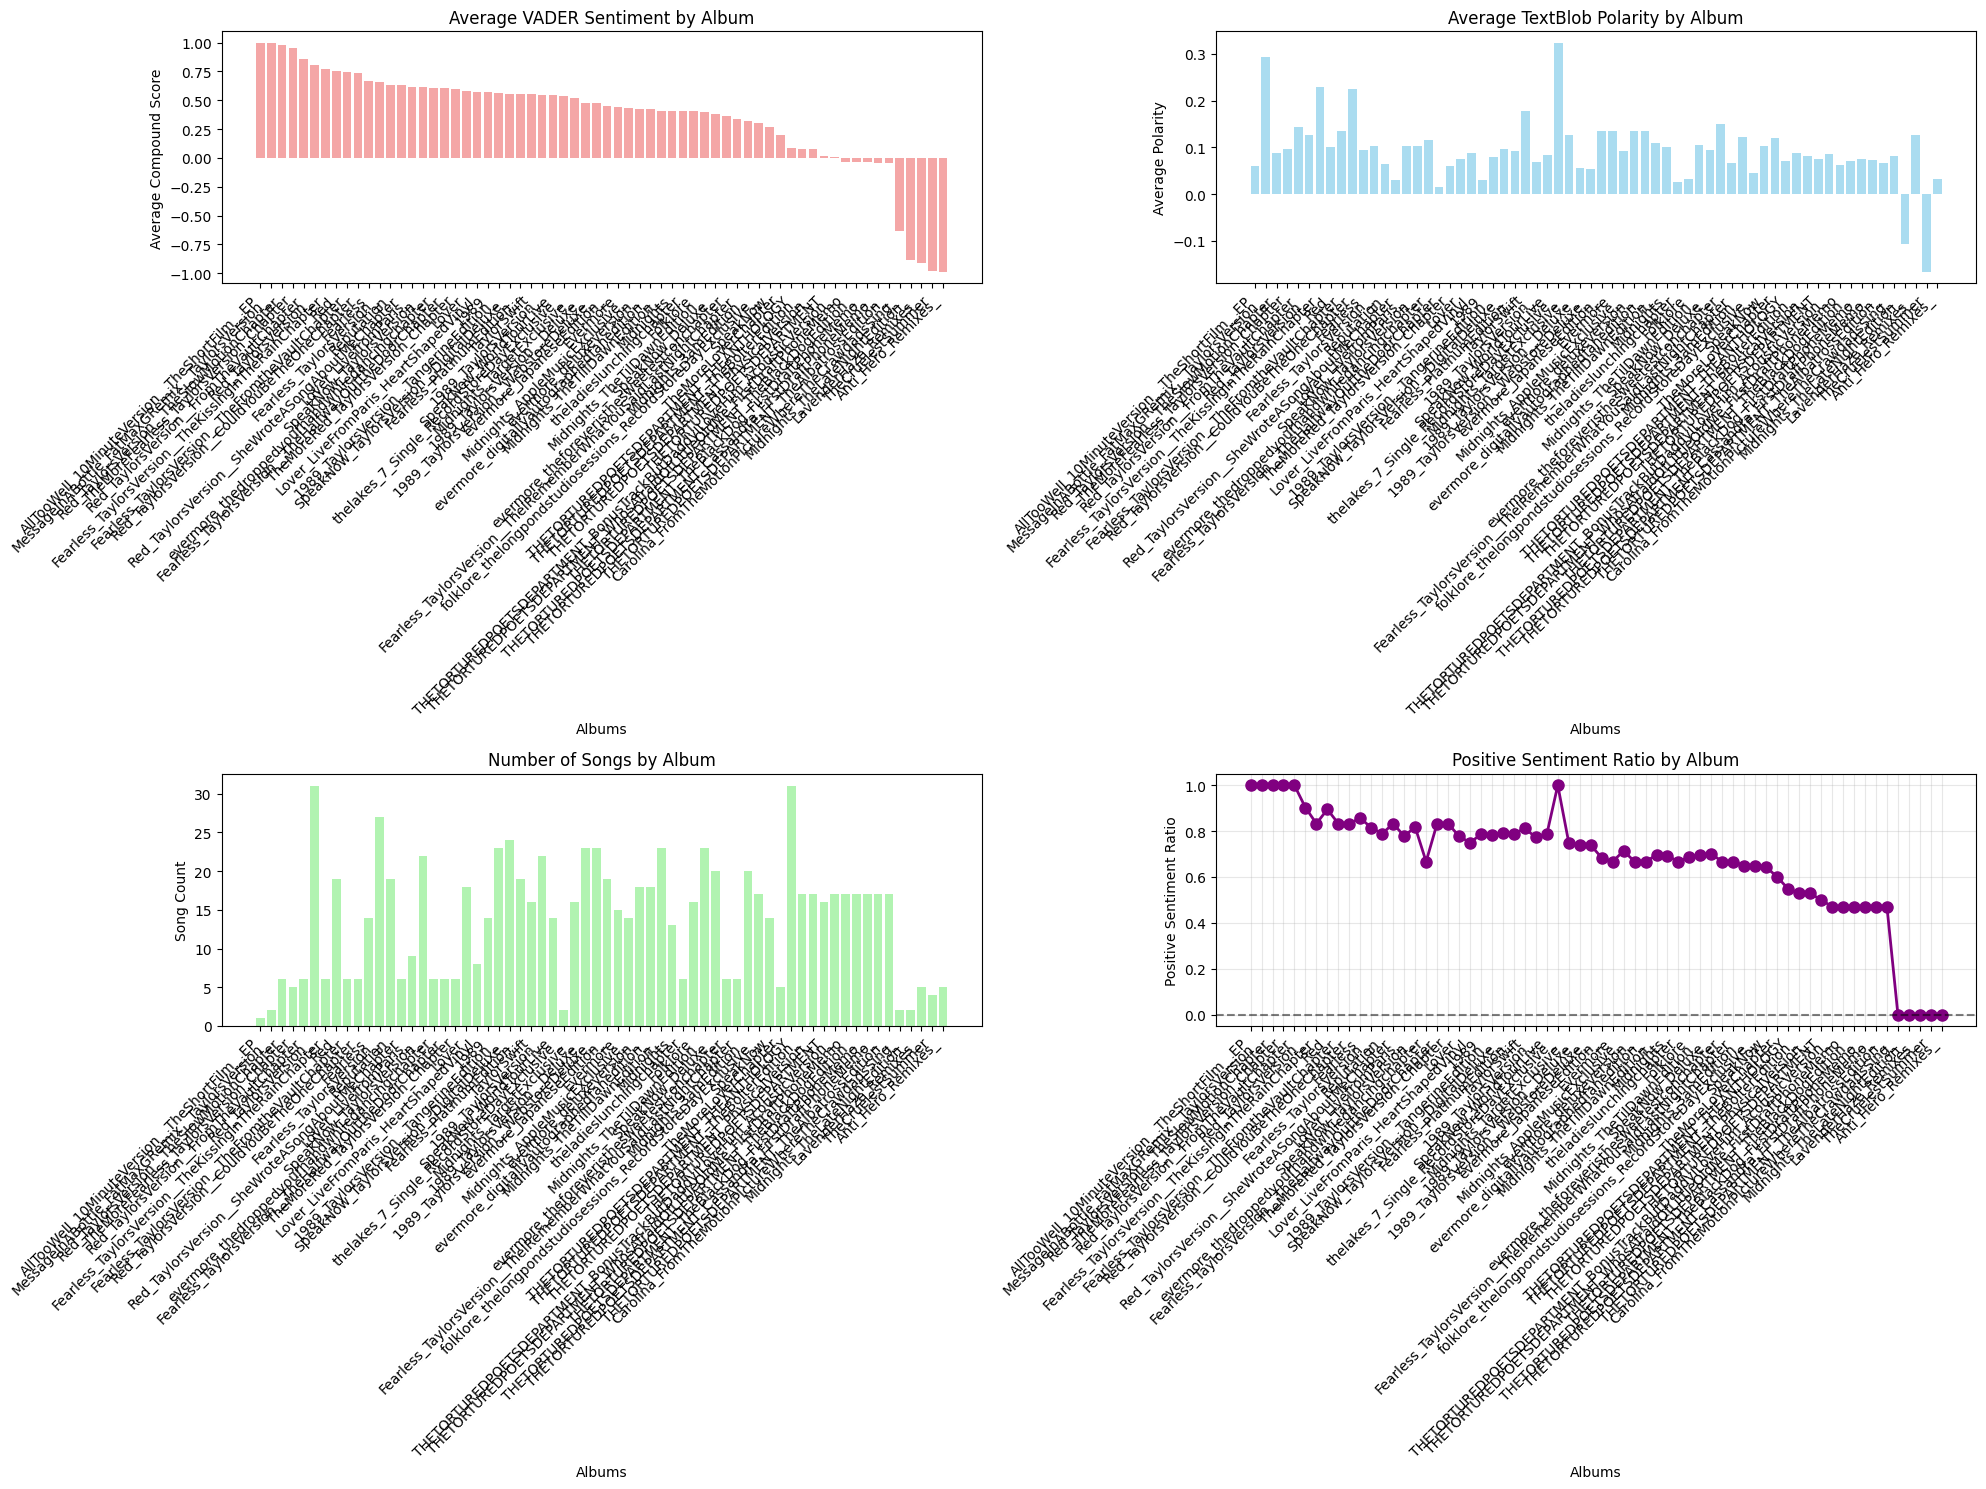


Top 3 Most Positive Songs:
  Suppository (from SpeakNow_WorldTourLive) - Score: 1.000
  Thislove (from 1989) - Score: 1.000
  Thislove Taylorsversion (from 1989_TaylorsVersion_) - Score: 1.000

Top 3 Most Negative Songs:
  Shakeitoff (from 1989) - Score: -1.000
  Shakeitoff Taylorsversion (from 1989_TaylorsVersion_) - Score: -1.000
  Shakeitoff Taylorsversion (from 1989_TaylorsVersion__TangerineEdition_) - Score: -1.000

Analyzing sentiment evolution...


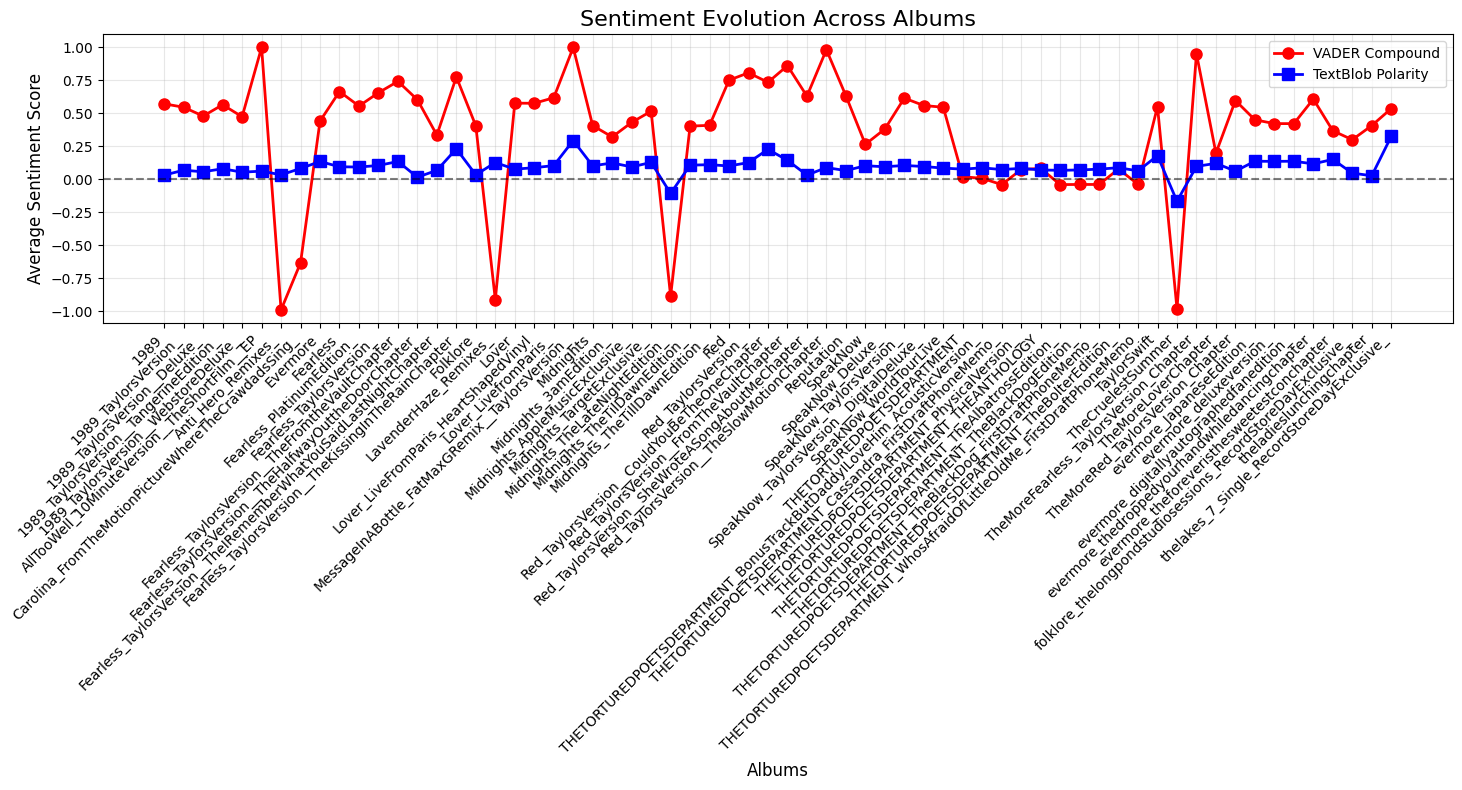


Would you like to export results to CSV? (y/n): y
Enter output file path (e.g., 'sentiment_results.csv'): sentiment_results.csv
Results exported to sentiment_results.csv

Analysis complete!


In [18]:
class ArtistLyricsSentimentAnalyzer:
    """
    A comprehensive sentiment analysis tool for artist's lyrics organized in folders
    """

    def __init__(self, base_folder_path):
        self.base_folder_path = Path(base_folder_path)
        self.vader_analyzer = SentimentIntensityAnalyzer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        self.model = None
        self.df = None

        # Folder structure
        self.albums_folder = self.base_folder_path / "Albums"
        self.cover_art_folder = self.base_folder_path / "Cover_Art"
        self.tabular_folder = self.base_folder_path / "Tabular"
        self.albums_csv = self.base_folder_path / "Albums1.csv"

        # Download NLTK data
        import nltk
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
        nltk.download('wordnet', quiet=True)
        nltk.download('punkt_tab', quiet=True) # Added punkt_tab download

    def load_album_metadata(self):
        """
        Load the main Albums1.csv file to get album information

        Returns:
            pandas.DataFrame: Album metadata
        """
        if not self.albums_csv.exists():
             print(f"Album metadata file not found at {self.albums_csv}")
             return None

        try:
            self.albums_df = pd.read_csv(self.albums_csv)
            # Check if expected columns exist
            if 'Albums' not in self.albums_df.columns or 'ID' not in self.albums_df.columns:
                 print(f"Error: Missing 'Albums' or 'ID' columns in {self.albums_csv}")
                 print(f"Found columns: {self.albums_df.columns.tolist()}")
                 return None
            print(f"Loaded {len(self.albums_df)} albums from metadata file")
            return self.albums_df
        except pd.errors.EmptyDataError:
            print(f"Error loading album metadata: {self.albums_csv} is empty.")
            return None
        except Exception as e:
            print(f"Error loading album metadata from {self.albums_csv}: {e}")
            return None

    def load_track_listings(self):
        """
        Load all track listing CSV files from the Tabular folder

        Returns:
            dict: Dictionary mapping album names to track DataFrames
        """
        track_listings = {}

        if not self.tabular_folder.exists():
            print("Tabular folder not found")
            return track_listings

        csv_files = list(self.tabular_folder.glob("*.csv"))
        print(f"Found {len(csv_files)} album track listing files in {self.tabular_folder}")

        for csv_file in csv_files:
            album_name = csv_file.stem  # Get filename without extension
            try:
                tracks_df = pd.read_csv(csv_file)
                 # Check if expected columns exist in track listing file
                if 'Tracks' not in tracks_df.columns or 'ID' not in tracks_df.columns:
                    print(f"Warning: Missing 'Tracks' or 'ID' columns in track listing file: {csv_file.name}")
                    continue # Skip this file if essential columns are missing

                track_listings[album_name] = tracks_df
                # print(f"Loaded {len(tracks_df)} tracks for album: {album_name}")
            except pd.errors.EmptyDataError:
                 print(f"Warning: Track listing file {csv_file.name} is empty.")
                 continue
            except Exception as e:
                print(f"Error loading tracks for {album_name} from {csv_file}: {e}")

        return track_listings

    def load_lyrics_from_files(self):
        """
        Load all lyrics from text files in the Albums folder structure

        Returns:
            pandas.DataFrame: Dataset with lyrics
        """
        all_songs = []

        if not self.albums_folder.exists():
            print(f"Albums folder not found at {self.albums_folder}")
            return pd.DataFrame()

        # Get all album folders
        album_folders = [f for f in self.albums_folder.iterdir() if f.is_dir()]
        print(f"Found {len(album_folders)} album folders in {self.albums_folder}")

        for album_folder in album_folders:
            album_name = album_folder.name
            # print(f"Processing album: {album_name}")

            # Get all text files in this album folder
            lyrics_files = list(album_folder.glob("*.txt"))
            # print(f"  Found {len(lyrics_files)} songs")

            for lyrics_file in lyrics_files:
                try:
                    # Read the lyrics file
                    with open(lyrics_file, 'r', encoding='utf-8', errors='ignore') as f:
                        lyrics_content = f.read()

                    # Skip if file is empty or too short
                    if len(lyrics_content.strip()) < 10:
                        # print(f"  Skipping {lyrics_file.name} - too short or empty")
                        continue

                    # Extract song name from filename
                    song_name = lyrics_file.stem
                    song_name = self.clean_song_name(song_name)

                    song_data = {
                        'album': album_name,
                        'song': song_name,
                        'lyrics': lyrics_content,
                        'file_path': str(lyrics_file),
                        'word_count': len(lyrics_content.split())
                    }

                    all_songs.append(song_data)

                except Exception as e:
                    print(f"  Error reading {lyrics_file.name}: {e}")

        # Create DataFrame
        self.df = pd.DataFrame(all_songs)

        if not self.df.empty:
            print(f"\nSuccessfully loaded {len(self.df)} songs with lyrics")
            print(f"Average words per song: {self.df['word_count'].mean():.1f}")
        else:
            print("No songs loaded - check your folder structure and file paths")

        return self.df

    def clean_song_name(self, filename):
        """
        Clean song name extracted from filename
        """
        if not isinstance(filename, str):
            return ""

        # Remove common prefixes like track numbers
        cleaned = re.sub(r'^\d+[\.\-\s]*', '', filename)

        # Remove common suffixes and file indicators
        cleaned = re.sub(r'\s*\(.*\)$', '', cleaned)
        cleaned = re.sub(r'\s*\[.*\]$', '', cleaned)

        # Replace underscores and hyphens with spaces
        cleaned = re.sub(r'[_-]', ' ', cleaned)

        # Clean up multiple spaces
        cleaned = ' '.join(cleaned.split())

        return cleaned.title()

    def merge_with_track_listings(self):
        """
        Merge lyrics data with track listing information
        """
        if self.df is None or self.df.empty:
            print("Lyrics data is not loaded or is empty. Cannot merge.")
            return

        print("Loading track listings for merging...")
        track_listings = self.load_track_listings()

        if not track_listings:
            print("No track listings loaded. Skipping merge.")
            return

        # Initialize track_id column before merging
        if 'track_id' not in self.df.columns:
             self.df['track_id'] = np.nan
        else:
             # Clear existing track_ids if the merge is being re-run
             self.df['track_id'] = np.nan


        print("Attempting to merge lyrics data with track listings...")
        songs_merged = 0
        for idx, row in self.df.iterrows():
            album_name = row['album']
            song_name = row['song']

            # Check if album exists in track listings dictionary
            if album_name in track_listings:
                tracks_df = track_listings[album_name]

                # Ensure the 'Tracks' column exists and is a string type in the track listing DataFrame
                if 'Tracks' not in tracks_df.columns or not pd.api.types.is_string_dtype(tracks_df['Tracks']):
                    # print(f"Warning: 'Tracks' column missing or not string type in track listing for album: {album_name}")
                    continue # Skip merging for this album if column is invalid

                # Try exact match first
                exact_match_mask = tracks_df['Tracks'].str.strip().str.lower() == song_name.strip().lower()

                if exact_match_mask.any(): # Use .any() to check if there's at least one match
                    self.df.at[idx, 'track_id'] = tracks_df.loc[exact_match_mask, 'ID'].iloc[0]
                    songs_merged += 1
                else:
                    # Try partial match (only if song_name is not empty)
                    if song_name: # Add check here
                        try:
                            first_word = song_name.split()[0]
                            partial_match_mask = tracks_df['Tracks'].str.contains(
                                re.escape(first_word), case=False, na=False)

                            if partial_match_mask.any(): # Use .any()
                                self.df.at[idx, 'track_id'] = tracks_df.loc[partial_match_mask, 'ID'].iloc[0]
                                songs_merged += 1
                        except IndexError:
                             # Handle cases where song_name.split() is empty after clean_song_name
                             # print(f"Warning: Could not perform partial match for empty song name in album {album_name}")
                             pass # Keep track_id as NaN for this song

        print(f"Merge attempt complete. Successfully matched track IDs for {songs_merged} songs.")


    def preprocess_lyrics(self, text):
        """
        Clean and preprocess lyrics text

        Args:
            text (str): Raw lyrics text

        Returns:
            str: Cleaned lyrics text
        """
        if pd.isna(text) or text == "":
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove verse markers, chorus indicators, etc.
        text = re.sub(r'\[.*?\]', '', text)  # Remove [Verse 1], [Chorus], etc.
        text = re.sub(r'\(.*?\)', '', text)   # Remove parenthetical notes

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        # Tokenize and remove stopwords
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]

        return ' '.join(tokens)

    def analyze_sentiment_textblob(self, text):
        """
        Analyze sentiment using TextBlob

        Args:
            text (str): Text to analyze

        Returns:
            dict: Sentiment scores
        """
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        if polarity > 0.1:
            sentiment = 'positive'
        elif polarity < -0.1:
            sentiment = 'negative'
        else:
            sentiment = 'neutral'

        return {
            'polarity': polarity,
            'subjectivity': subjectivity,
            'sentiment': sentiment
        }

    def analyze_sentiment_vader(self, text):
        """
        Analyze sentiment using VADER

        Args:
            text (str): Text to analyze

        Returns:
            dict: Sentiment scores
        """
        scores = self.vader_analyzer.polarity_scores(text)

        # Determine overall sentiment
        if scores['compound'] >= 0.05:
            sentiment = 'positive'
        elif scores['compound'] <= -0.05:
            sentiment = 'negative'
        else:
            sentiment = 'neutral'

        return {
            'compound': scores['compound'],
            'positive': scores['pos'],
            'negative': scores['neg'],
            'neutral': scores['neu'],
            'sentiment': sentiment
        }

    def analyze_dataset(self):
        """
        Perform sentiment analysis on the entire dataset
        """
        if self.df is None or self.df.empty:
            print("No data to analyze. Please load data first using load_lyrics_from_files()")
            # Initialize sentiment columns with NaNs or defaults to avoid errors later
            self.df = pd.DataFrame(columns=['album', 'song', 'lyrics', 'file_path', 'word_count',
                                            'track_id', 'album_id', 'clean_lyrics',
                                            'tb_polarity', 'tb_subjectivity', 'tb_sentiment',
                                            'vader_compound', 'vader_positive', 'vader_negative',
                                            'vader_neutral', 'vader_sentiment'])
            return self.df

        print("Preprocessing lyrics...")
        # Apply preprocessing only if 'lyrics' column exists and is not empty
        if 'lyrics' in self.df.columns and not self.df['lyrics'].empty:
            # Ensure 'lyrics' column is string type
            self.df['lyrics'] = self.df['lyrics'].astype(str)
            self.df['clean_lyrics'] = self.df['lyrics'].apply(self.preprocess_lyrics)
        else:
            print("No 'lyrics' column or lyrics data found for preprocessing.")
            self.df['clean_lyrics'] = "" # Add empty column to avoid errors

        print("Analyzing sentiment with TextBlob...")
        # Apply TextBlob analysis only if 'lyrics' column exists and is not empty
        if 'lyrics' in self.df.columns and not self.df['lyrics'].empty:
            textblob_results = self.df['lyrics'].apply(self.analyze_sentiment_textblob)
            self.df['tb_polarity'] = [r['polarity'] for r in textblob_results]
            self.df['tb_subjectivity'] = [r['subjectivity'] for r in textblob_results]
            self.df['tb_sentiment'] = [r['sentiment'] for r in textblob_results]
        else:
             print("No 'lyrics' column or lyrics data found for TextBlob analysis.")
             self.df['tb_polarity'] = np.nan
             self.df['tb_subjectivity'] = np.nan
             self.df['tb_sentiment'] = "neutral"


        print("Analyzing sentiment with VADER...")
        # Apply VADER analysis only if 'lyrics' column exists and is not empty
        if 'lyrics' in self.df.columns and not self.df['lyrics'].empty:
            vader_results = self.df['lyrics'].apply(self.analyze_sentiment_vader)
            self.df['vader_compound'] = [r['compound'] for r in vader_results]
            self.df['vader_positive'] = [r['positive'] for r in vader_results]
            self.df['vader_negative'] = [r['negative'] for r in vader_results]
            self.df['vader_neutral'] = [r['neutral'] for r in vader_results]
            self.df['vader_sentiment'] = [r['sentiment'] for r in vader_results]
        else:
            print("No 'lyrics' column or lyrics data found for VADER analysis.")
            self.df['vader_compound'] = np.nan
            self.df['vader_positive'] = np.nan
            self.df['vader_negative'] = np.nan
            self.df['vader_neutral'] = np.nan
            self.df['vader_sentiment'] = "neutral"


        print("Sentiment analysis complete!")
        return self.df

    def analyze_by_album(self):
        """
        Analyze sentiment by album
        """
        if self.df is None or self.df.empty or 'tb_polarity' not in self.df.columns:
            print("Please run analyze_dataset() first and ensure data was analyzed.")
            return

        # Ensure necessary columns exist before grouping
        required_cols = ['album', 'tb_polarity', 'vader_compound', 'tb_sentiment', 'vader_sentiment', 'song']
        if not all(col in self.df.columns for col in required_cols):
            print("Missing necessary columns for album analysis. Please check previous steps.")
            return pd.DataFrame() # Return empty DataFrame to prevent further errors


        album_sentiment = self.df.groupby('album').agg({
            'tb_polarity': ['mean', 'std'],
            'vader_compound': ['mean', 'std'],
            'tb_sentiment': lambda x: (x == 'positive').mean() if not x.empty else np.nan,
            'vader_sentiment': lambda x: (x == 'positive').mean() if not x.empty else np.nan,
            'song': 'count'
        }).round(3)

        # Flatten column names
        album_sentiment.columns = ['TB_Avg_Polarity', 'TB_Std_Polarity',
                                  'VADER_Avg_Compound', 'VADER_Std_Compound',
                                  'TB_Positive_Ratio', 'VADER_Positive_Ratio',
                                  'Song_Count']

        # Sort by average VADER compound score, handling NaNs
        album_sentiment = album_sentiment.sort_values('VADER_Avg_Compound', ascending=False, na_position='last')


        print("\nSentiment Analysis by Album:")
        print(album_sentiment)

        return album_sentiment

    def visualize_album_sentiment(self):
        """
        Create visualizations for album-based sentiment analysis
        """
        if self.df is None or self.df.empty or 'vader_compound' not in self.df.columns:
            print("Please run analyze_dataset() first and ensure data was analyzed.")
            return

        album_sentiment = self.analyze_by_album()

        if album_sentiment is None or album_sentiment.empty:
            print("No album sentiment data to visualize.")
            return


        fig, axes = plt.subplots(2, 2, figsize=(20, 15))

        # Album sentiment comparison
        albums = album_sentiment.index
        x_pos = np.arange(len(albums))

        # VADER compound scores by album
        axes[0,0].bar(x_pos, album_sentiment['VADER_Avg_Compound'],
                     color='lightcoral', alpha=0.7)
        axes[0,0].set_title('Average VADER Sentiment by Album')
        axes[0,0].set_xlabel('Albums')
        axes[0,0].set_ylabel('Average Compound Score')
        axes[0,0].set_xticks(x_pos)
        axes[0,0].set_xticklabels(albums, rotation=45, ha='right')

        # TextBlob polarity by album
        axes[0,1].bar(x_pos, album_sentiment['TB_Avg_Polarity'],
                     color='skyblue', alpha=0.7)
        axes[0,1].set_title('Average TextBlob Polarity by Album')
        axes[0,1].set_xlabel('Albums')
        axes[0,1].set_ylabel('Average Polarity')
        axes[0,1].set_xticks(x_pos)
        axes[0,1].set_xticklabels(albums, rotation=45, ha='right')

        # Song count by album
        axes[1,0].bar(x_pos, album_sentiment['Song_Count'], color='lightgreen', alpha=0.7)
        axes[1,0].set_title('Number of Songs by Album')
        axes[1,0].set_xlabel('Albums')
        axes[1,0].set_ylabel('Song Count')
        axes[1,0].set_xticks(x_pos)
        axes[1,0].set_xticklabels(albums, rotation=45, ha='right')

        # Sentiment evolution over time (if albums can be ordered chronologically)
        # For now, we'll show positive ratio by album
        axes[1,1].plot(x_pos, album_sentiment['VADER_Positive_Ratio'],
                      marker='o', linewidth=2, markersize=8, color='purple')
        axes[1,1].set_title('Positive Sentiment Ratio by Album')
        axes[1,1].set_xlabel('Albums')
        axes[1,1].set_ylabel('Positive Sentiment Ratio')
        axes[1,1].set_xticks(x_pos)
        axes[1,1].set_xticklabels(albums, rotation=45, ha='right')
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5) # Corrected ax to axes[1,1]


        plt.tight_layout()
        plt.show()

    def load_complete_dataset(self):
        """
        Load the complete dataset by combining all sources

        Returns:
            pandas.DataFrame: Complete dataset
        """
        print("Loading album metadata...")
        albums_metadata = self.load_album_metadata()
        if albums_metadata is None:
             print("Album metadata loading failed.")
             return None
        print("Album metadata loaded successfully.")


        print("Loading lyrics from files...")
        lyrics_df = self.load_lyrics_from_files()
        if lyrics_df is None or lyrics_df.empty:
            print("No lyrics data loaded")
            return None
        self.df = lyrics_df.copy() # Assign loaded lyrics to self.df
        print("Lyrics loaded successfully.")

        print("Merging with track listings...")
        self.merge_with_track_listings()


        # Add album ID information if available
        if albums_metadata is not None and self.df is not None and not self.df.empty:
            # Create a mapping from album name to ID
            # Ensure both columns exist in albums_metadata before creating the map
            if 'Albums' in albums_metadata.columns and 'ID' in albums_metadata.columns:
                 album_id_map = dict(zip(albums_metadata['Albums'], albums_metadata['ID']))
                 # Use .loc to avoid SettingWithCopyWarning and apply map
                 self.df.loc[:, 'album_id'] = self.df['album'].map(album_id_map)
            else:
                 print("Warning: 'Albums' or 'ID' column missing in album metadata. Cannot add album IDs.")


        if self.df is not None and not self.df.empty:
            print(f"Complete dataset loaded with {len(self.df)} songs across {self.df['album'].nunique()} albums")
        else:
            print("Complete dataset could not be loaded.")

        return self.df

    def load_lyrics_from_files(self):
        """
        Load all lyrics from text files in the Albums folder structure

        Returns:
            pandas.DataFrame: Dataset with lyrics
        """
        all_songs = []

        if not self.albums_folder.exists():
            print(f"Albums folder not found at {self.albums_folder}")
            return pd.DataFrame()

        # Get all album folders
        album_folders = [f for f in self.albums_folder.iterdir() if f.is_dir()]
        print(f"Found {len(album_folders)} album folders in {self.albums_folder}")

        for album_folder in album_folders:
            album_name = album_folder.name
            # print(f"Processing album: {album_name}")

            # Get all text files in this album folder
            lyrics_files = list(album_folder.glob("*.txt"))
            # print(f"  Found {len(lyrics_files)} songs")

            for lyrics_file in lyrics_files:
                try:
                    # Read the lyrics file
                    with open(lyrics_file, 'r', encoding='utf-8', errors='ignore') as f:
                        lyrics_content = f.read()

                    # Skip if file is empty or too short
                    if len(lyrics_content.strip()) < 10:
                        # print(f"  Skipping {lyrics_file.name} - too short or empty")
                        continue

                    # Extract song name from filename
                    song_name = lyrics_file.stem
                    song_name = self.clean_song_name(song_name)

                    song_data = {
                        'album': album_name,
                        'song': song_name,
                        'lyrics': lyrics_content,
                        'file_path': str(lyrics_file),
                        'word_count': len(lyrics_content.split())
                    }

                    all_songs.append(song_data)

                except Exception as e:
                    print(f"  Error reading {lyrics_file.name}: {e}")

        # Create DataFrame
        self.df = pd.DataFrame(all_songs)

        if not self.df.empty:
            print(f"\nSuccessfully loaded {len(self.df)} songs with lyrics")
            print(f"Average words per song: {self.df['word_count'].mean():.1f}")
        else:
            print("No songs loaded - check your folder structure and file paths")

        return self.df

    def clean_song_name(self, filename):
        """
        Clean song name extracted from filename
        """
        if not isinstance(filename, str):
            return ""

        # Remove common prefixes like track numbers
        cleaned = re.sub(r'^\d+[\.\-\s]*', '', filename)

        # Remove common suffixes and file indicators
        cleaned = re.sub(r'\s*\(.*\)$', '', cleaned)
        cleaned = re.sub(r'\s*\[.*\]$', '', cleaned)

        # Replace underscores and hyphens with spaces
        cleaned = re.sub(r'[_-]', ' ', cleaned)

        # Clean up multiple spaces
        cleaned = ' '.join(cleaned.split())

        return cleaned.title()

    def merge_with_track_listings(self):
        """
        Merge lyrics data with track listing information
        """
        if self.df is None or self.df.empty:
            print("Lyrics data is not loaded or is empty. Cannot merge.")
            return

        print("Loading track listings for merging...")
        track_listings = self.load_track_listings()

        if not track_listings:
            print("No track listings loaded. Skipping merge.")
            return

        # Initialize track_id column before merging
        if 'track_id' not in self.df.columns:
             self.df['track_id'] = np.nan
        else:
             # Clear existing track_ids if the merge is being re-run
             self.df['track_id'] = np.nan


        print("Attempting to merge lyrics data with track listings...")
        songs_merged = 0
        for idx, row in self.df.iterrows():
            album_name = row['album']
            song_name = row['song']

            # Check if album exists in track listings dictionary
            if album_name in track_listings:
                tracks_df = track_listings[album_name]

                # Ensure the 'Tracks' column exists and is a string type in the track listing DataFrame
                if 'Tracks' not in tracks_df.columns or not pd.api.types.is_string_dtype(tracks_df['Tracks']):
                    # print(f"Warning: 'Tracks' column missing or not string type in track listing for album: {album_name}")
                    continue # Skip merging for this album if column is invalid

                # Try exact match first
                exact_match_mask = tracks_df['Tracks'].str.strip().str.lower() == song_name.strip().lower()

                if exact_match_mask.any(): # Use .any() to check if there's at least one match
                    self.df.at[idx, 'track_id'] = tracks_df.loc[exact_match_mask, 'ID'].iloc[0]
                    songs_merged += 1
                else:
                    # Try partial match (only if song_name is not empty)
                    if song_name: # Add check here
                        try:
                            first_word = song_name.split()[0]
                            partial_match_mask = tracks_df['Tracks'].str.contains(
                                re.escape(first_word), case=False, na=False)

                            if partial_match_mask.any(): # Use .any()
                                self.df.at[idx, 'track_id'] = tracks_df.loc[partial_match_mask, 'ID'].iloc[0]
                                songs_merged += 1
                        except IndexError:
                             # Handle cases where song_name.split() is empty after clean_song_name
                             # print(f"Warning: Could not perform partial match for empty song name in album {album_name}")
                             pass # Keep track_id as NaN for this song

        print(f"Merge attempt complete. Successfully matched track IDs for {songs_merged} songs.")


    def get_dataset_overview(self):
        """
        Print overview of the loaded dataset
        """
        if self.df is None or self.df.empty:
            print("No data loaded")
            return

        print("="*60)
        print("DATASET OVERVIEW")
        print("="*60)

        print(f"Total songs: {len(self.df)}")
        print(f"Total albums: {self.df['album'].nunique()}")
        print(f"Average songs per album: {len(self.df) / self.df['album'].nunique():.1f}")
        print(f"Total words across all songs: {self.df['word_count'].sum():,}")
        print(f"Average words per song: {self.df['word_count'].mean():.1f}")
        print(f"Longest song: {self.df['word_count'].max()} words")
        print(f"Shortest song: {self.df['word_count'].min()} words")

        print(f"\nAlbums in dataset:")
        album_counts = self.df['album'].value_counts().sort_index()
        for album, count in album_counts.items():
            print(f"  {album}: {count} songs")

    def analyze_sentiment_evolution(self):
        """
        Analyze how sentiment evolves across albums (chronologically if possible)
        """
        if self.df is None or self.df.empty or 'vader_compound' not in self.df.columns:
            print("Please run analyze_dataset() first and ensure data was analyzed.")
            return

        # Ensure necessary columns exist before grouping
        required_cols = ['album', 'vader_compound', 'tb_polarity', 'song']
        if not all(col in self.df.columns for col in required_cols):
            print("Missing necessary columns for sentiment evolution analysis. Please check previous steps.")
            return pd.DataFrame() # Return empty DataFrame to prevent further errors


        album_sentiment = self.df.groupby('album').agg({
            'vader_compound': ['mean', 'std'],
            'tb_polarity': ['mean', 'std'],
            'song': 'count'
        }).round(3)

        if album_sentiment.empty:
            print("No album sentiment data to visualize evolution.")
            return

        # Flatten column names
        album_sentiment.columns = ['_'.join(col).strip() for col in album_sentiment.columns.values]
        album_sentiment = album_sentiment.rename(columns={'song_count': 'Song_Count'})


        # Plot sentiment evolution
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))

        albums = album_sentiment.index
        x_pos = np.arange(len(albums))

        # Plot both VADER and TextBlob trends
        ax.plot(x_pos, album_sentiment['vader_compound_mean'],
               marker='o', linewidth=2, markersize=8, label='VADER Compound', color='red')
        ax.plot(x_pos, album_sentiment['tb_polarity_mean'],
               marker='s', linewidth=2, markersize=8, label='TextBlob Polarity', color='blue')

        ax.set_title('Sentiment Evolution Across Albums', fontsize=16)
        ax.set_xlabel('Albums', fontsize=12)
        ax.set_ylabel('Average Sentiment Score', fontsize=12)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(albums, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)


        plt.tight_layout()
        plt.show()

        return album_sentiment

    def find_emotional_extremes(self, n=5):
        """
        Find the most positive and negative songs

        Args:
            n (int): Number of songs to return for each category
        """
        if self.df is None or self.df.empty or 'vader_compound' not in self.df.columns:
            print("Please run analyze_dataset() first and ensure data was analyzed.")
            return

        # Ensure necessary columns exist before finding extremes
        required_cols = ['album', 'song', 'vader_compound', 'tb_polarity']
        if not all(col in self.df.columns for col in required_cols):
            print("Missing necessary columns for finding emotional extremes. Please check previous steps.")
            return {'most_positive': pd.DataFrame(), 'most_negative': pd.DataFrame()}


        # Most positive songs
        most_positive = self.df.nlargest(n, 'vader_compound')[
            ['album', 'song', 'vader_compound', 'tb_polarity']]

        # Most negative songs
        most_negative = self.df.nsmallest(n, 'vader_compound')[
            ['album', 'song', 'vader_compound', 'tb_polarity']]

        print(f"\nTop {n} Most Positive Songs:")
        if not most_positive.empty:
            for idx, row in most_positive.iterrows():
                print(f"  {row['song']} (from {row['album']}) - Score: {row['vader_compound']:.3f}")
        else:
            print("  No positive songs found.")

        print(f"\nTop {n} Most Negative Songs:")
        if not most_negative.empty:
            for idx, row in most_negative.iterrows():
                print(f"  {row['song']} (from {row['album']}) - Score: {row['vader_compound']:.3f}")
        else:
            print("  No negative songs found.")


        return {'most_positive': most_positive, 'most_negative': most_negative}

    def export_results(self, output_path):
        """
        Export analysis results to CSV

        Args:
            output_path (str): Path where to save the results
        """
        if self.df is None or self.df.empty:
            print("No data to export")
            return

        # Create a clean export dataframe, ensuring columns exist
        export_cols = ['album', 'song', 'word_count', 'tb_polarity',
                       'tb_subjectivity', 'tb_sentiment', 'vader_compound',
                       'vader_positive', 'vader_negative', 'vader_neutral',
                       'vader_sentiment']
        # Filter for columns that actually exist in the dataframe
        existing_cols = [col for col in export_cols if col in self.df.columns]
        export_df = self.df[existing_cols].copy()


        try:
            export_df.to_csv(output_path, index=False)
            print(f"Results exported to {output_path}")
        except Exception as e:
            print(f"Error exporting results to {output_path}: {e}")


def main():
    """
    Example usage of the ArtistLyricsSentimentAnalyzer
    """
    # Initialize the analyzer with your base folder path
    base_folder = r"/content/data"

    # Alternative: ask for path if you want to make it flexible
    # base_folder = input("Enter the path to your main dataset folder: ").strip()

    analyzer = ArtistLyricsSentimentAnalyzer(base_folder)

    # Load the complete dataset
    print("Loading complete dataset...")
    df = analyzer.load_complete_dataset()

    if df is None or df.empty:
        print("Failed to load dataset. Please check your folder structure and file contents.")
        return

    # Get dataset overview
    analyzer.get_dataset_overview()

    # Perform sentiment analysis
    print("\nPerforming sentiment analysis...")
    analyzer.analyze_dataset()

    # Analyze by album
    print("\nAnalyzing sentiment by album...")
    album_analysis = analyzer.analyze_by_album()

    # Visualize results
    print("\nGenerating visualizations...")
    analyzer.visualize_album_sentiment()

    # Find emotional extremes
    emotional_extremes = analyzer.find_emotional_extremes(n=3)

    # Analyze sentiment evolution
    print("\nAnalyzing sentiment evolution...")
    evolution_analysis = analyzer.analyze_sentiment_evolution()

    # Export results
    export_choice = input("\nWould you like to export results to CSV? (y/n): ").strip().lower()
    if export_choice == 'y':
        output_path = input("Enter output file path (e.g., 'sentiment_results.csv'): ").strip()
        analyzer.export_results(output_path)

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()